In [38]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from tensorflow.python.ops import parallel_for as pfor
import imageio

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import plot_N, plot_FP, name_best_ckpt, make_axes, make_h_combined, same_stim_trial
from tools_lnd import get_model_params
from tools_lnd import gen_trials_from_model_dir,gen_X_from_model_dir, get_stim_cats

PATH_TO_RECURRENT_WHISPERER = p+'/code/recurrent-whisperer'#'/home/laura/code/recurrent-whisperer'#
sys.path.insert(0, PATH_TO_RECURRENT_WHISPERER)
from RecurrentWhisperer import RecurrentWhisperer

PATH_TO_FIXED_POINT_FINDER = p+'/code/fixed-point-finder' #'/home/laura/code/fixed-point-finder-experimental'#
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
from FixedPointFinder import FixedPointFinder

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

tab20 = plt.get_cmap('tab20')
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
color_inds = (tab20c(8/20),tab20c(9/20),tab20c(10/20),tab20c(4/20),tab20c(5/20),tab20c(6/20),
             tab20b(0/20),tab20b(12/20),tab20b(1/20),tab20b(13/20),tab20b(16/20),
             tab20b(2/20),tab20b(14/20),tab20b(3/20),tab20b(15/20),tab20b(17/20),
             tab20(18/20),tab20(19/20),tab20(16/20),tab20(17/20))

In [5]:
def get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch):
    
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
    
    #get trial structure and activity for specific model and task
    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(h_rule, hparams, mode='random', noise_on=False, batch_size=1000,delay_fac = 1)# get feed_dict
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

    #dim reduction w either pca or regression    
    N = np.shape(h_tf)[2]
    X = np.reshape(h_tf,[-1,N])

    # pca = PCA(n_components = 2)
    # X_pca = pca.fit_transform(X)

    X_pca = np.dot(X,D)
    X_pca_shaped = np.reshape(X_pca,[np.shape(h_tf)[0],np.shape(h_tf)[1],2])

    #dim recuction in output space
    w_in, b_in, w_out, b_out = get_model_params(model_dir_all,ckpt_n_dir)
    X_wout = np.dot(X,w_out[:,1:])
    X_wout_shaped = np.reshape(X_wout,[np.shape(h_tf)[0],np.shape(h_tf)[1],2])

    stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial)

    #time windows for stim presentations 1 and 2
    T1 = range(trial.epochs['stim1'][0]-1,trial.epochs['stim1'][1])
    T2 = range(trial.epochs['go1'][0],np.shape(h_tf)[0])
    step_size = 5

    #concatenate all category vectors
    b1 = np.mean(h_tf[T1[0]:T1[0]+step_size,np.ix_(stim1_cats),:],axis = 2)
    b0 = np.mean(h_tf[T1[0]:T1[0]+step_size,np.ix_(~stim1_cats),:],axis = 2)
    b11 = np.mean(h_tf[T2[0]:T2[0]+step_size,np.ix_(stim1_cats & stim2_cats),:],axis = 2)
    b10 = np.mean(h_tf[T2[0]:T2[0]+step_size,np.ix_(stim1_cats & ~stim2_cats),:],axis = 2)
    b01 = np.mean(h_tf[T2[0]:T2[0]+step_size,np.ix_(~stim1_cats & stim2_cats),:],axis = 2)
    b00 = np.mean(h_tf[T2[0]:T2[0]+step_size,np.ix_(~stim1_cats & ~stim2_cats),:],axis = 2)

    b_cat = np.concatenate((b1,b01,b11,b0,b10,b00),axis = 1)
    return b_cat, trial, D, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs

In [49]:
#visualize activity and category vectors
def vis_cat_vecs(b_cat, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,n_trials,
                 vec_color = 'k',lw = 5):
    for e in ['stim1','delay1','go1']:

        T_end = trial.epochs[e][1], 
        if T_end[0] is None:
            T_end = np.shape(trial.x)

        T_start = trial.epochs[e][0], 
        if T_start[0] is None:
            T_start = (1,)

        T = range(T_start[0]-1,T_end[0])

#         fig = plt.figure(figsize=(20,6),tight_layout=True,facecolor='white')
#         cmap=plt.get_cmap('rainbow')
#         plt.rcParams.update({'font.size': 20})

        for t in range(np.min([np.shape(X_pca_shaped)[1],n_trials])):

            ax1 = plt.subplot(1,3,1)

            if trial.y_loc[-1,t]/(np.pi*2)<0:
                c = [.5,.5,.5]
                al = .5
            else:
                c = cmap(stim1_locs[t]/(np.pi*2))
                al = 1

            plt.plot(X_pca_shaped[:,t,0],X_pca_shaped[:,t,1],c = c,alpha = 0)
            plt.plot(X_pca_shaped[T,t,0],X_pca_shaped[T,t,1],c = c,alpha = al)
            cat_line = np.dot(b_cat[:,0,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],c = vec_color,alpha = 1,linewidth = lw)
            cat_line = np.dot(b_cat[:,3,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],':',c = vec_color,alpha = 1,linewidth = lw)

            plt.xlabel(axes_rule + ' TDR on ' + axes_epoch + r' $\cos{\theta}$')
            plt.ylabel(axes_rule + ' TDR on ' + axes_epoch + r' $\sin{\theta}$') 
            plt.title(e + ' Activity Colored by Stim1')

            ax2 = plt.subplot(1,3,2)

            if trial.y_loc[-1,t]/(np.pi*2)<0:
                c = [.5,.5,.5]
                al = .5
            else:
                c = cmap(stim2_locs[t]/(np.pi*2))
                al = 1

            plt.plot(X_pca_shaped[:,t,0],X_pca_shaped[:,t,1],c = c,alpha = 0)
            plt.plot(X_pca_shaped[T,t,0],X_pca_shaped[T,t,1],c = c,alpha = al)

            cat_line = np.dot(b_cat[:,1,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],c = vec_color,alpha = 1,linewidth = lw)
            cat_line = np.dot(b_cat[:,4,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],':',c = vec_color,alpha = 1,linewidth = lw)

            cat_line = np.dot(b_cat[:,2,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],c = vec_color,alpha = 1,linewidth = lw)
            cat_line = np.dot(b_cat[:,5,:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],':',c = vec_color,alpha = 1,linewidth = lw)

            plt.xlabel(axes_rule + ' TDR on ' + axes_epoch + r' $\cos{\theta}$')
            plt.ylabel(axes_rule + ' TDR on ' + axes_epoch + r' $\sin{\theta}$') 
            plt.title(e + ' Activity Colored by Stim2')

            ax3 = plt.subplot(1,3,3)

            if trial.y_loc[-1,t]/(np.pi*2)<0:
                c = [.5,.5,.5]
                al = .5
            else:
                c = cmap(trial.y_loc[-1,t]/(np.pi*2))
                al = 1

            plt.plot(X_wout_shaped[:,t,0],X_wout_shaped[:,t,1],c = c,alpha = 0)
            plt.plot(X_wout_shaped[T,t,0],X_wout_shaped[T,t,1],c = c,alpha = 1)
            plt.plot(X_wout_shaped[T[-1],t,0],X_wout_shaped[T[-1],t,1],'o',c = c,alpha = 1)

            plt.xlabel('Output Axis '+r'$\cos{\theta}$')
            plt.ylabel('Output Axis '+r'$\sin{\theta}$') 
            plt.title(e + ' Colored by Target')

        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        plt.savefig(fldr+h_rule+'_activity_'+e+'.pdf')
        plt.savefig(fldr+h_rule+'_activity_'+e+'.png')

In [17]:
np.shape(stim1_locs[:,np.newaxis])

(1000, 1)

In [24]:
cat_set_solid = [(0),(0),(1,2)]
cat_set_dot = [(3,),(3),(4,5)]
print(cat_set_dot[0])

3


In [50]:
#visualize activity and category vectors
def vis_cat_vecs_minimal(b_cat, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,n_trials,
                 vec_color = 'k',lw = 5,show_cat = 1,show_activity = 1):
    
    epoch_set = ['stim1','delay1','go1']
    cmap_set = np.concatenate((stim1_locs[:,np.newaxis],stim1_locs[:,np.newaxis],stim2_locs[:,np.newaxis]),axis = 1)
    cat_set_solid = [(0,),(0,),(1,2)]
    cat_set_dot = [(3,),(3,),(4,5)]
    
    
#     fig = plt.figure(figsize=(len(epoch_set)*6+2,6),tight_layout=True,facecolor='white')
#     cmap=plt.get_cmap('rainbow')
    
    for e_ind in range(len(epoch_set)):
        e = epoch_set[e_ind]

        T_end = trial.epochs[e][1], 
        if T_end[0] is None:
            T_end = np.shape(trial.x)

        T_start = trial.epochs[e][0], 
        if T_start[0] is None:
            T_start = (1,)

        T = range(T_start[0]-1,T_end[0])


        for t in range(np.min([np.shape(X_pca_shaped)[1],n_trials])):

            ax1 = plt.subplot(1,len(epoch_set),e_ind+1)

            if trial.y_loc[-1,t]/(np.pi*2)<0:
                c = [.5,.5,.5]
                al = .5
            else:
                c = cmap(cmap_set[t,e_ind]/(np.pi*2))
                al = 1

            if show_activity==1:
                plt.plot(X_pca_shaped[:,t,0],X_pca_shaped[:,t,1],c = c,alpha = 0)
                plt.plot(X_pca_shaped[T,t,0],X_pca_shaped[T,t,1],c = c,alpha = al)

            if show_cat==1:
                for cat_ind in cat_set_solid[e_ind]:
                    cat_line = np.dot(b_cat[:,cat_ind,:],D)
                    plt.plot(cat_line[:,0],cat_line[:,1],c = vec_color,alpha = 1,linewidth = lw)
                    
                for cat_ind in cat_set_dot[e_ind]:
                    cat_line = np.dot(b_cat[:,cat_ind,:],D)
                    plt.plot(cat_line[:,0],cat_line[:,1],':',c = vec_color,alpha = 1,linewidth = lw)
            plt.axis('off')
            plt.xlim((-.3,.3))
            plt.ylim((-.3,.3))
            
        plt.tight_layout()
        
    if show_activity==1 & show_cat==1:
        plt.savefig(fldr+h_rule+'_activity_'+e+'_act_cat_minimal.pdf')
        plt.savefig(fldr+h_rule+'_activity_'+e+'_act_cat_minimal.png')
    elif show_cat==1:
        plt.savefig(fldr+h_rule+'_activity_'+e+'_cat_minimal.pdf')
        plt.savefig(fldr+h_rule+'_activity_'+e+'_cat_minimal.png')
    elif show_activity==1:
        plt.savefig(fldr+h_rule+'_activity_'+e+'_act_minimal.pdf')
        plt.savefig(fldr+h_rule+'_activity_'+e+'_act_minimal.png')

In [8]:
net = 'stepnet'
model_n = 0
rule = 'dmcgo'
dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2w0001'#''crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

In [9]:
fldr = os.path.join(model_dir_all,'category_boundary/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [43]:
print(color_inds[18])

(0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

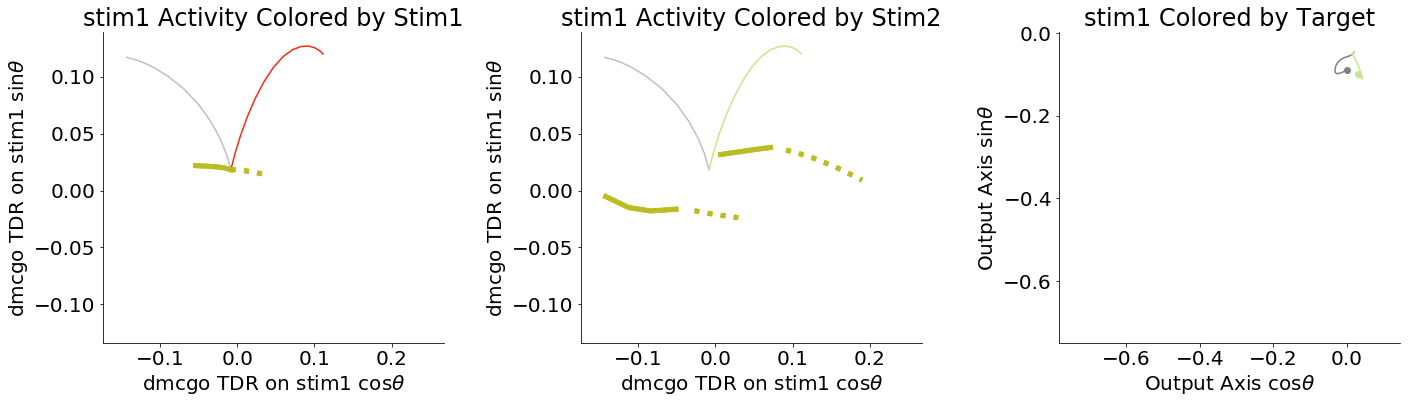

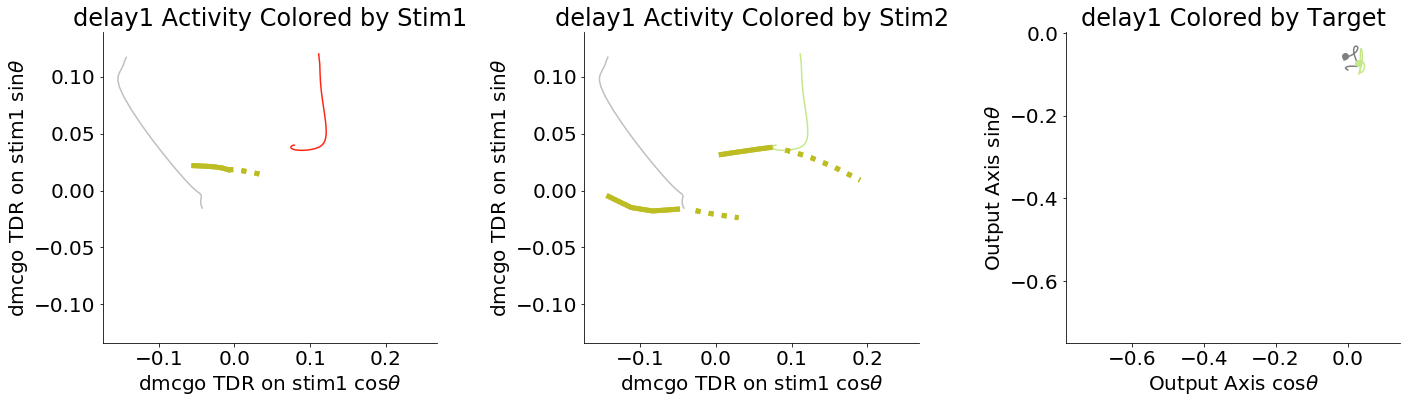

In [44]:
h_rule = 'dmcgo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

b_cat_nogo,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs(b_cat_nogo, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 2, vec_color = color_inds[18])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

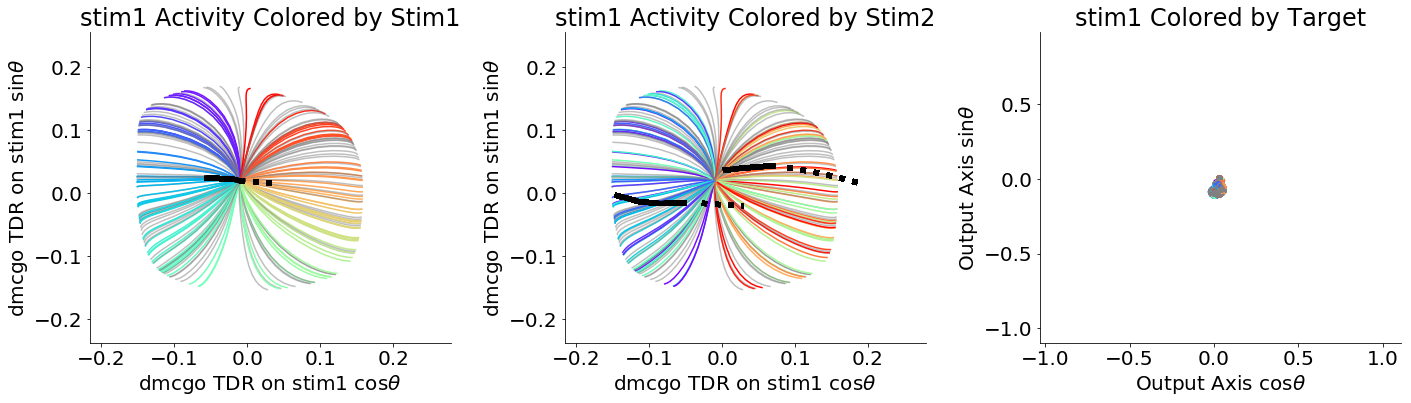

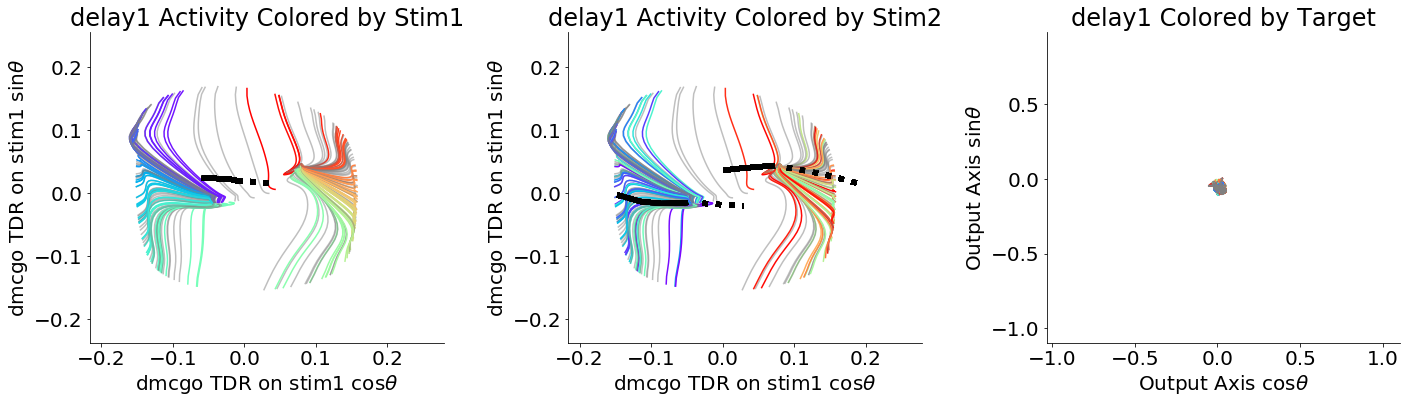

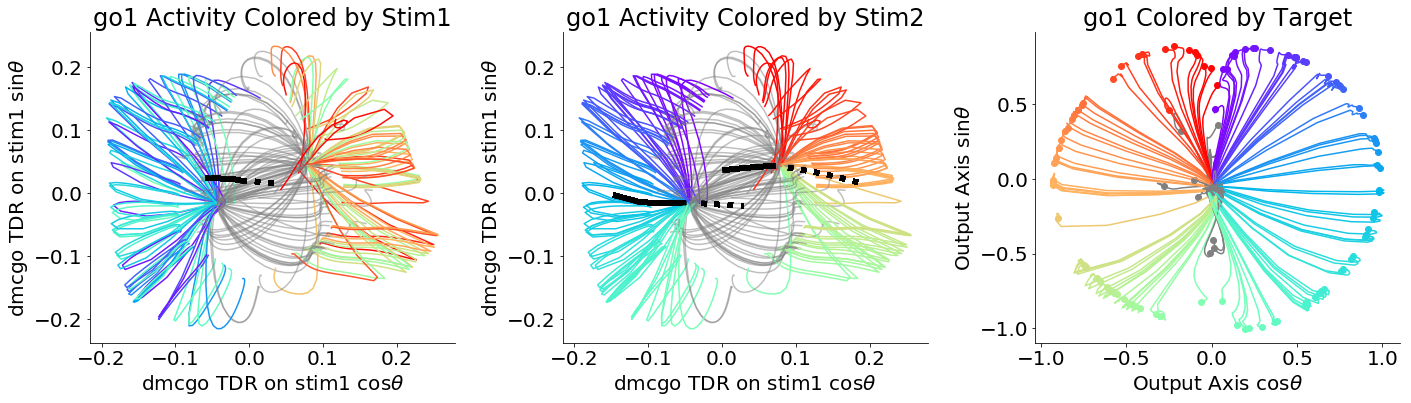

In [7]:
h_rule = 'dmcgo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

b_cat_go,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,200)

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

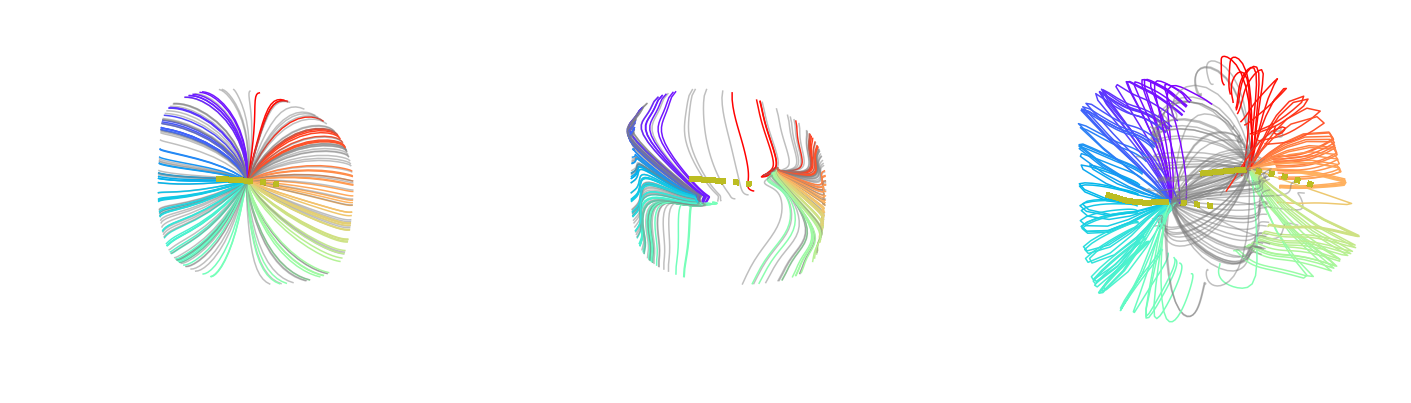

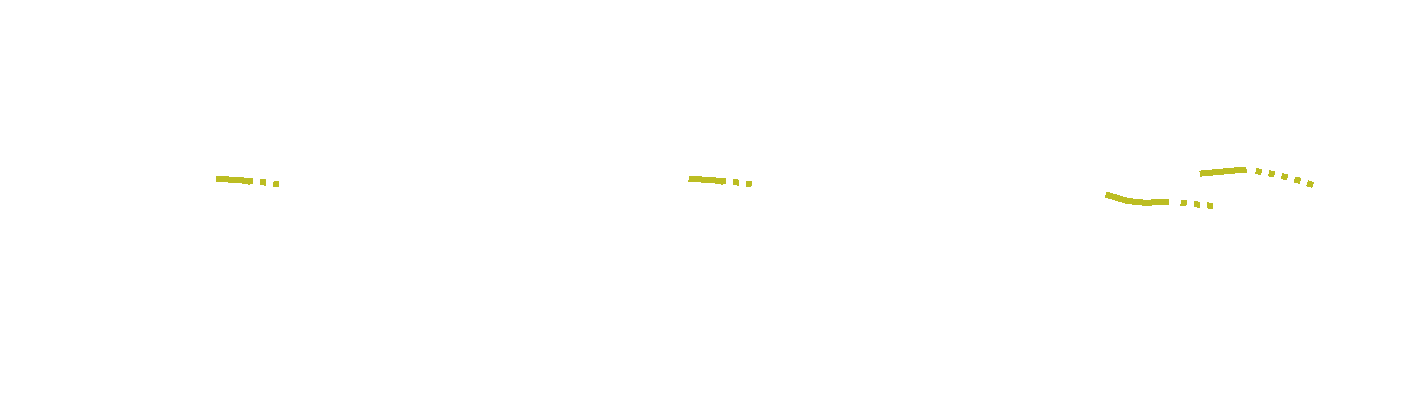

In [45]:
h_rule = 'dmcgo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

b_cat_go,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,200,vec_color = color_inds[18])

vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 
                     200,show_cat = 1,show_activity = 0,vec_color = color_inds[18])
plt.show()
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 
                     200,show_cat = 0,show_activity = 1)
plt.show()

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

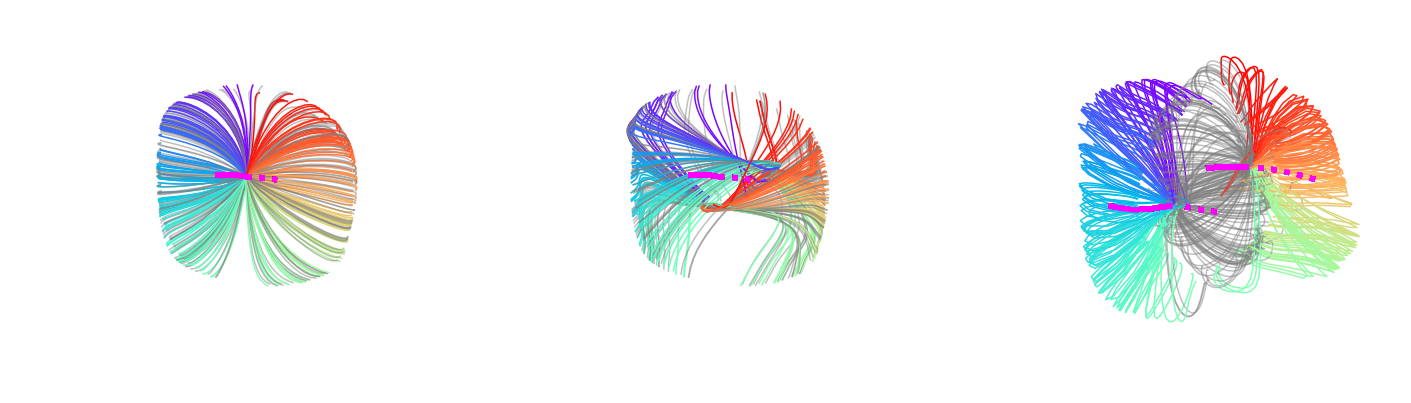

In [51]:
h_rule = 'dmcgo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

fig = plt.figure(figsize=(20,6),tight_layout=True,facecolor='white')
cmap=plt.get_cmap('rainbow')
plt.rcParams.update({'font.size': 20})
        
b_cat_go,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 
                     200,show_cat = 0,show_activity = 1)

h_rule = 'dmcnogo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

b_cat_go,trial,_,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,200,vec_color = 'magenta')

In [37]:
h_rule = 'dmcnogo'
axes_rule = 'dmcgo'
axes_epoch = 'stim1'

b_cat_go,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,200,vec_color = 'magenta')
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 
                     200,show_cat = 1,show_activity = 0,vec_color = 'magenta')
vis_cat_vecs_minimal(b_cat_go, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs, 
                     200,show_cat = 0,show_activity = 1,vec_color = 'magenta')

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

In [52]:
def plot_h_struct_multi_stim(model_dir_all,ckpt_n_dir,tasks,trial_set,trial_master,D,time_inds,
                             color_inds,rot = 0,dot_alpha = .5,line_alpha = .5):
    
    stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial_master)
    cmap=plt.get_cmap('rainbow')
    
    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        hparams = model.hp

        for rule_ind in tasks:
            trial = same_stim_trial(trial_master, rule_ind)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            for s in trial_set:
                
                if rule_ind>17:
                    if trial_master.y_loc[-1,s]/(np.pi*2)<0:
                        c = [.5,.5,.5]
                        dot_alpha = dot_alpha/2
                        line_alpha = line_alpha/2
                    else:
                        c = cmap(stim2_locs[s]/(np.pi*2))
                        dot_alpha = dot_alpha
                        line_alpha = line_alpha
                
                ax1 = plt.subplot(1,2,1)
#                 c = color_inds[rule_ind]
                X_trial = np.dot(h_tf[time_inds,s,:],D)
#                 plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1,alpha = line_alpha)
#                 plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1,alpha = line_alpha)
                
                if s==trial_set[0]:
                    plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, markersize = 10,alpha = dot_alpha,label = rule_set_names[rule_ind])
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, markersize = 3,alpha = dot_alpha)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1.5,alpha = line_alpha)
                else:
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1.5,alpha = line_alpha)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, markersize = 3,alpha = dot_alpha)
                    
                ax2 = plt.subplot(1,2,2)
                c = cmap(s/np.max(trial_set))
                
                if rule_ind>17:
                    if trial.y_loc[-1,s]/(np.pi*2)<0:
                        c = [.5,.5,.5]
                        dot_alpha = dot_alpha/2
                        line_alpha = line_alpha/2
                    else:
                        c = cmap(stim1_locs[s]/(np.pi*2))
                        dot_alpha = dot_alpha
                        line_alpha = line_alpha
                
                if s==trial_set[0]:
#                     plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, markersize = 10,alpha = dot_alpha,label = rule_set_names[rule_ind])
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, markersize = 3,alpha = dot_alpha)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1.5,alpha = line_alpha)
                else:
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1.5,alpha = line_alpha)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, markersize = 3,alpha = dot_alpha)
        
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        plt.xlabel('PC1')
        plt.ylabel('PC2') 
        plt.title('Stimulus Activity Colored by Stimulus')
        
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ylims = ax1.get_ylim()
        xlims = ax1.get_xlim()
        plt.subplot(1,2,1)        
        plt.xlabel('PC1')
        plt.ylabel('PC2') 
        plt.title('Stimulus Activity Colored by Task')
        
        return xlims,ylims

In [53]:
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp

    for rule_ind in tasks:
        trial = same_stim_trial(trial_master, rule_ind)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


NameError: name 'tasks' is not defined

In [ ]:
fldr

In [67]:
def project_trial_mat(h,D):
    X = np.reshape(h,(-1,h.shape[2]))
    XD = np.dot(X,D)
    hD = np.reshape(XD,(h.shape[0],h.shape[1],D.shape[1]))
    return hD

def get_h_struct_multi_stim(model_dir_all,ckpt_n_dir,trial_master,D,tasks,time_inds,trial_set):
    h_set = {} 
    y_set = {} 
    c_task_set = {}
    c_stim_set = {}
    
    stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial_master)
    cmap=plt.get_cmap('rainbow')
    
    if tasks[0]==18:
        gray_trials = stim1_cats!=stim2_cats
    else:
        gray_trials = stim1_cats==stim2_cats
            
    stim1_cmap = cmap(stim1_locs/(np.pi*2))
#     stim1_cmap[gray_trials,:] = .5
    stim2_cmap = cmap(stim2_locs/(np.pi*2))
    stim2_cmap[gray_trials,:] = .5
    
    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        hparams = model.hp

        for rule_ind in tasks:
            trial = same_stim_trial(trial_master, rule_ind)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            h_trial_subset = h_tf[:,trial_set,:]
            y_trial_subset = y_hat[:,trial_set,:]
            hD = project_trial_mat(h_trial_subset[time_inds,:,:],D)
            h_set[rules_dict['all'][rule_ind]] = hD
            y_set[rules_dict['all'][rule_ind]] = y_trial_subset[time_inds,:,1:]
            c_task_set[rules_dict['all'][rule_ind]] = stim1_cmap
            c_stim_set[rules_dict['all'][rule_ind]] = stim2_cmap
        
    return h_set, y_set, c_task_set, c_stim_set

def get_trial_animate_stats(trial_master,trial_ind):
    trial_x = trial_master.x[:,trial_ind,:]
    y_trial_subset = trial_master.y[:,trial_ind,1:]
    T,N = np.shape(trial_x)
    
    stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial_master)
    cmap=plt.get_cmap('rainbow')
            
    stim1_cmap = cmap(stim1_locs[trial_ind]/(np.pi*2))
    stim2_cmap = cmap(stim2_locs[trial_ind]/(np.pi*2))
    
    for t in range(0,T):
        fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
        plt.rcParams.update({'font.size': 16})
        plt.plot(trial_x[t,1],trial_x[t,2],markersize = 30,c = stim1_cmap)
    
    

def gen_gif_dynamics(hD_set,y_set,c_task_set,c_stim_set,movie_dir,xlims,ylims):
    
    task_set = hD_set.keys()
    T,S,N = np.shape(hD_set[task_set[0]])
    
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    for t in range(0,T):
        
        fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
        plt.rcParams.update({'font.size': 16})
        cmap=plt.get_cmap('rainbow')

        for task in task_set:

            X = hD_set[task]

            l1 = t+1
            l0 = np.max([l1-10, 0])
            ind = range(l0,l1)

            for s in range(S):
                
#                 ax1 = plt.subplot(1,3,1)
#                 plt.plot(hD_set[task][ind,s,0],hD_set[task][ind,s,1],'-',linewidth = 3,c = c_task_set[task][s],alpha = .5)
#                 plt.plot(hD_set[task][l1-1,s,0],hD_set[task][l1-1,s,1],'o',c = c_task_set[task][s],alpha = 1)
                
#                 ax2 = plt.subplot(1,3,2)
                ax2 = plt.subplot(1,1,1)
                plt.plot(hD_set[task][ind,s,0],hD_set[task][ind,s,1],'-',linewidth = 3,c = c_stim_set[task][s],alpha = .5)
                plt.plot(hD_set[task][l1-1,s,0],hD_set[task][l1-1,s,1],'o',c = c_task_set[task][s],alpha = 1)
                
#                 ax3 = plt.subplot(1,3,3)
#                 plt.plot(y_set[task][ind,s,0],y_set[task][ind,s,1],'-',linewidth = 3,c = c_stim_set[task][s],alpha = .5)
#                 plt.plot(y_set[task][l1-1,s,0],y_set[task][l1-1,s,1],'o',c = c_stim_set[task][s],alpha = 1)
                
#         ax1 = plt.subplot(1,3,1)        
#         plt.xlim(xlims)
#         plt.ylim(ylims)
#         plt.axis('off')
        
#         ax1 = plt.subplot(1,3,2)
        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.axis('off')
        
#         ax3 = plt.subplot(1,3,3)
#         plt.xlim([-1.2,1.2])
#         plt.ylim([-1.2,1.2])
#         ax3.spines['right'].set_visible(False)
#         ax3.spines['top'].set_visible(False)
        
        plt.savefig(movie_dir +'/'+ str(t) + '.png')
        plt.show()
        
def animate_mult_tasks(model_dir_all,ckpt_n_dir,fig_title,D,trial_master,tasks,time_inds,trial_set,xlims,ylims):

    fldr = os.path.join(model_dir_all,'FP_layout/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    movie_dir = os.path.join(fldr,fig_title)

    n_trials = np.shape(trial_master.x)[1]
    trial_inds = range(0,n_trials,int(n_trials/100))

    h_set,y_set,c_task_set,c_stim_set = get_h_struct_multi_stim(model_dir_all,ckpt_n_dir,trial_master,D,tasks,time_inds,trial_set)
    gen_gif_dynamics(h_set,y_set,c_task_set,c_stim_set,movie_dir,xlims,ylims)

    images = []
    for t in range(len(time_inds)-1):#T*xt):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))
    imageio.mimsave(movie_dir+'/movie.gif', images)

In [70]:
def plot_epoch(trial_master,epoch,task_num,rules_dict):
    n_trials = np.shape(trial_master.x)[1]
    trial_set = range(0,n_trials)
    trial_inds = range(trial_master.epochs[epoch][0],trial_master.epochs[epoch][1])
    ax2 = plt.subplot(1,1,1)

    hD_set,y_set,c_task_set,c_stim_set = get_h_struct_multi_stim(model_dir_all,ckpt_n_dir,trial_master,D,(task_num,),trial_inds,trial_set)
    stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial_master)
    task = rules_dict['all'][task_num]
    X = hD_set[task]
    for s in trial_set:
        plt.plot(X[:,s,0],X[:,s,1],'-',linewidth = 3,c = cmap(stim1_locs[s]/(2*np.pi)),alpha = .5)

In [55]:
noise_on = False
model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials('dmcgo', hparams, mode = 'random', batch_size = 200, noise_on=noise_on, delay_fac =1)   

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


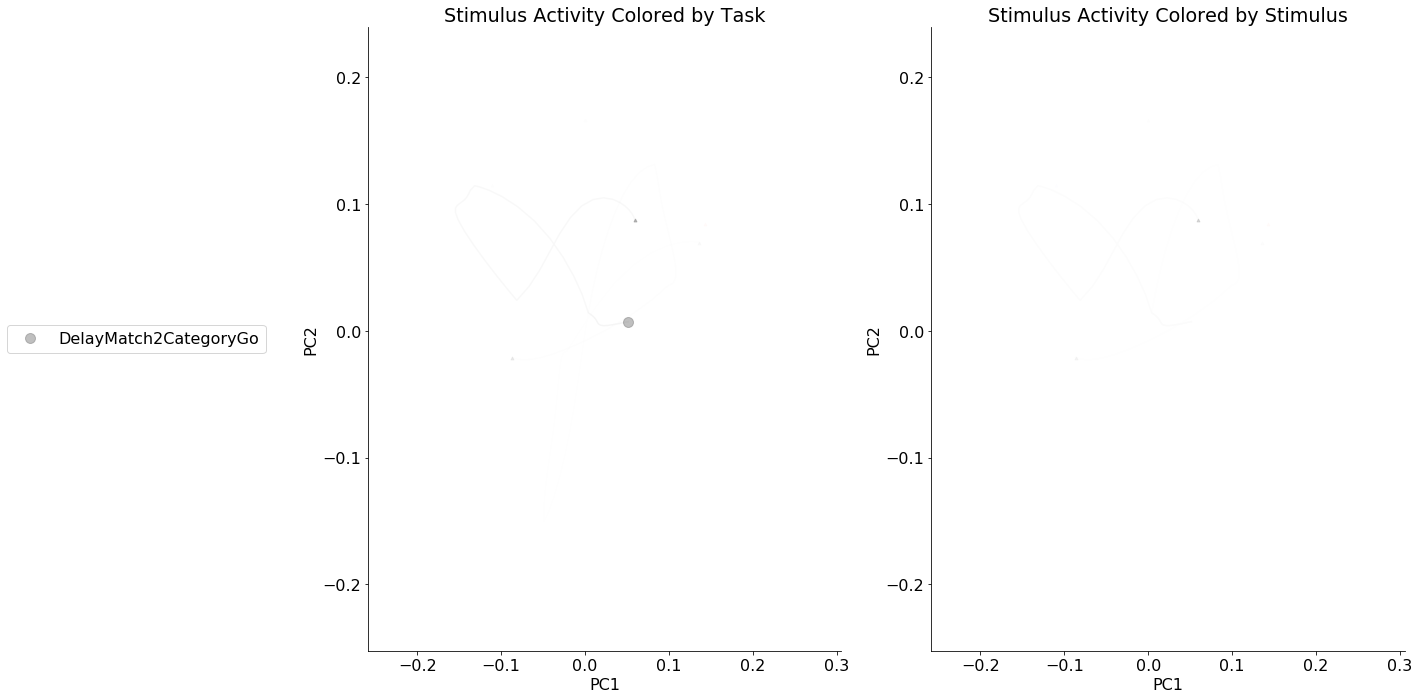

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


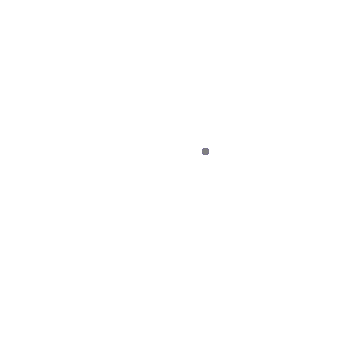

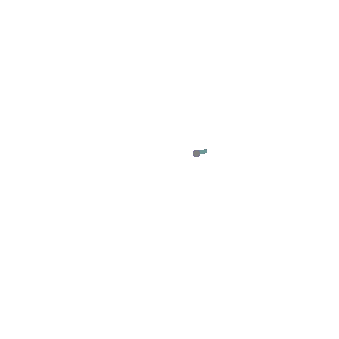

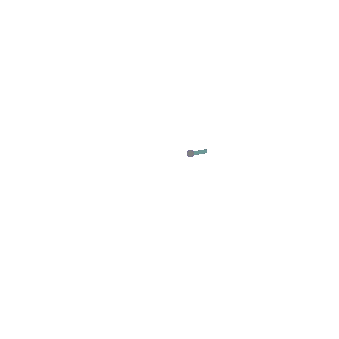

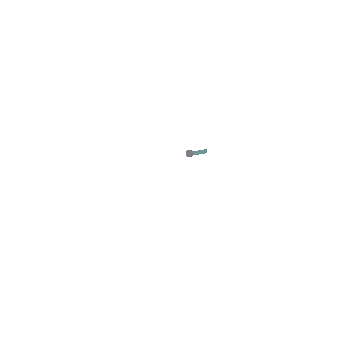

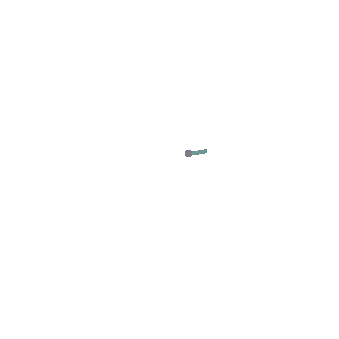

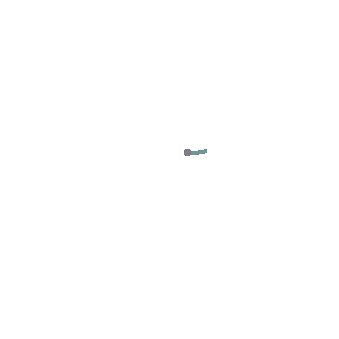

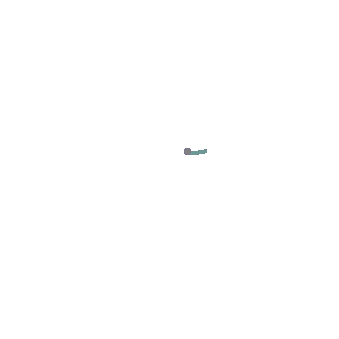

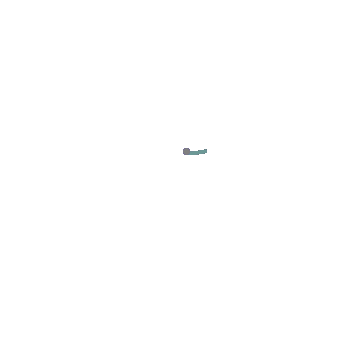

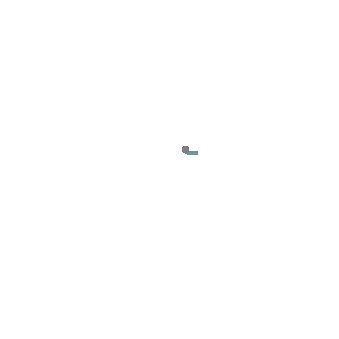

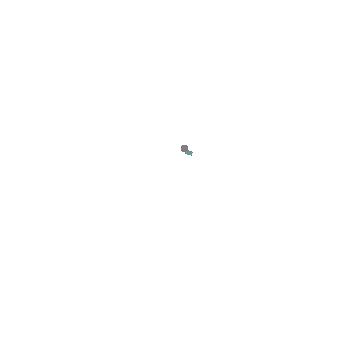

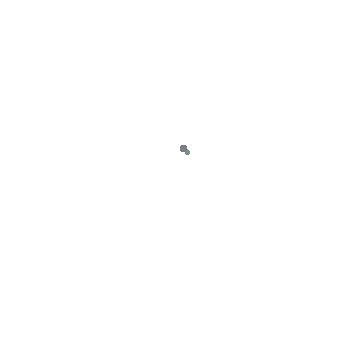

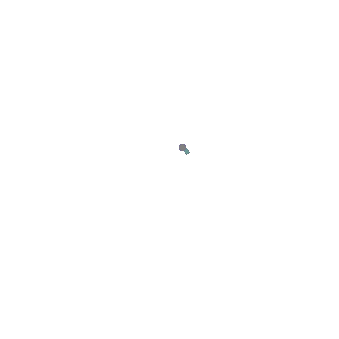

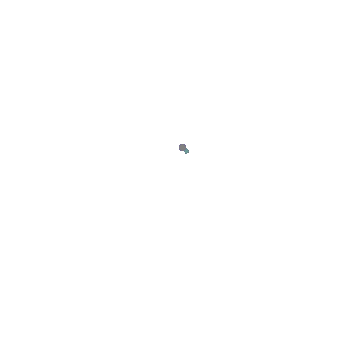

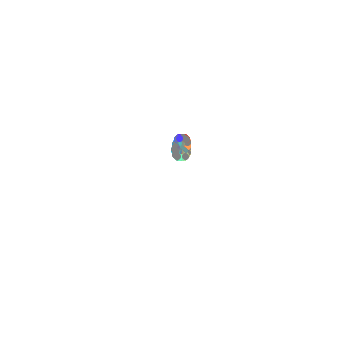

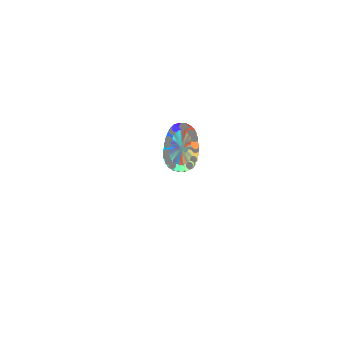

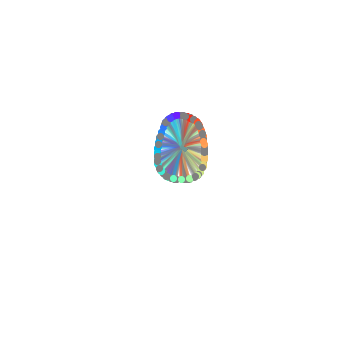

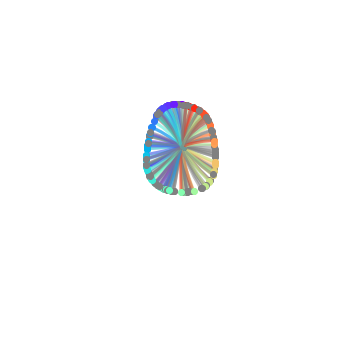

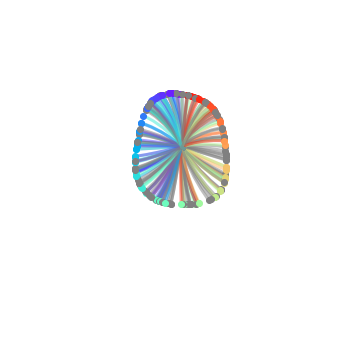

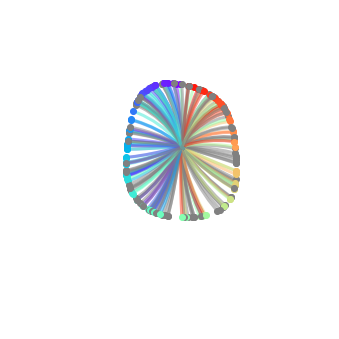

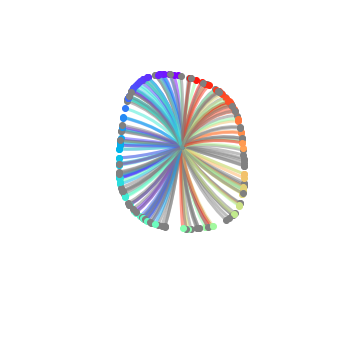

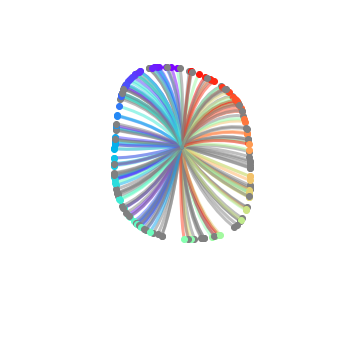

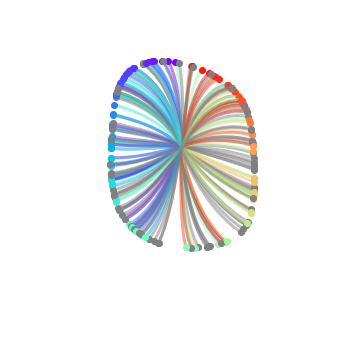

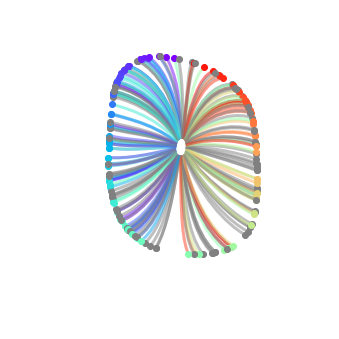

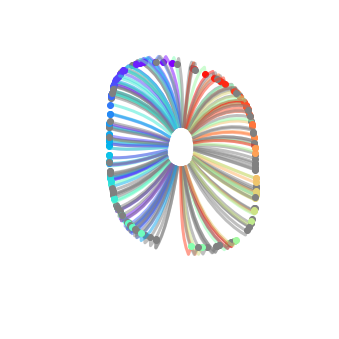

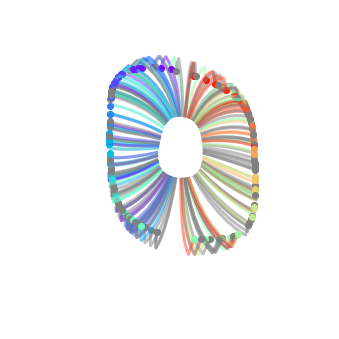

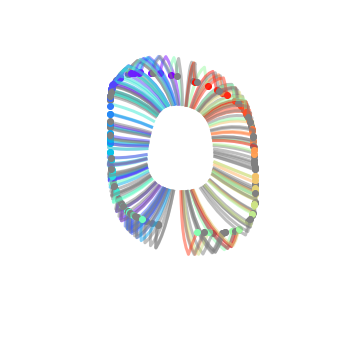

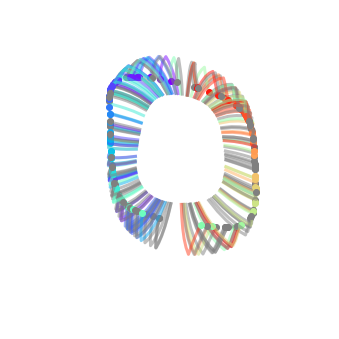

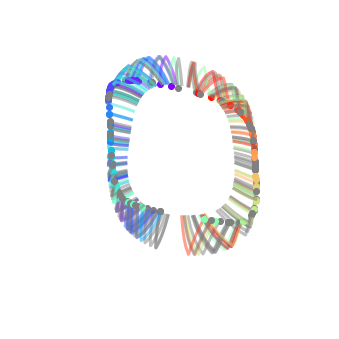

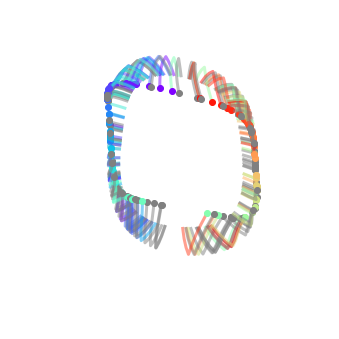

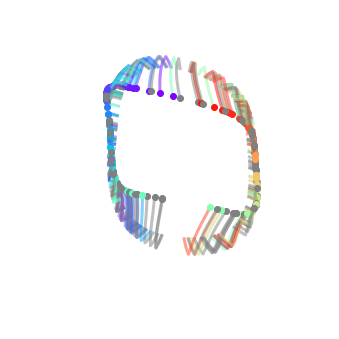

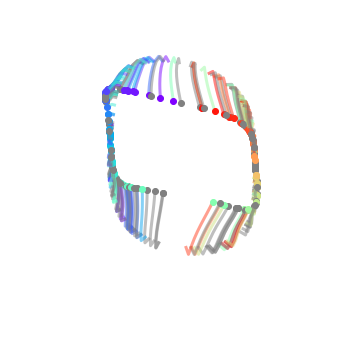

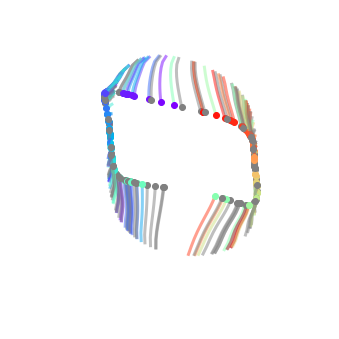

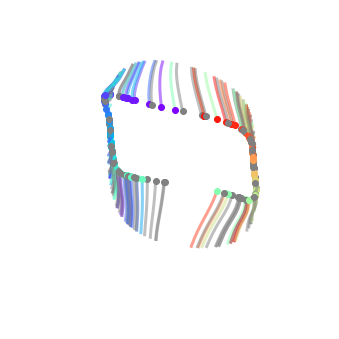

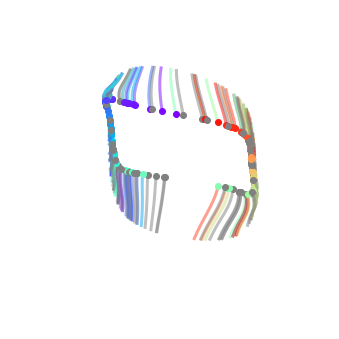

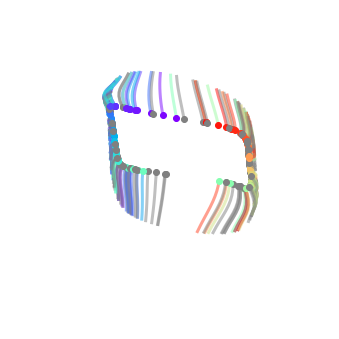

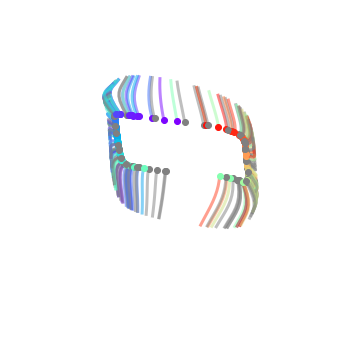

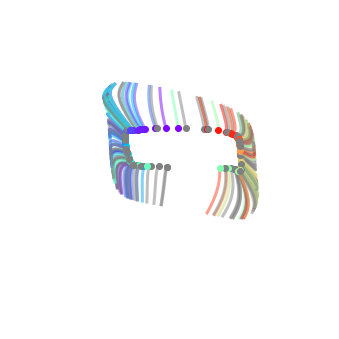

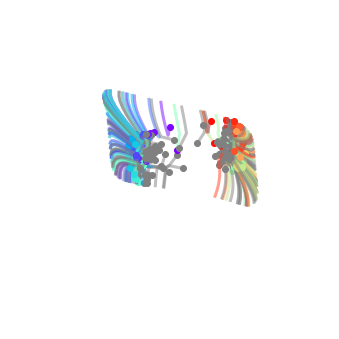

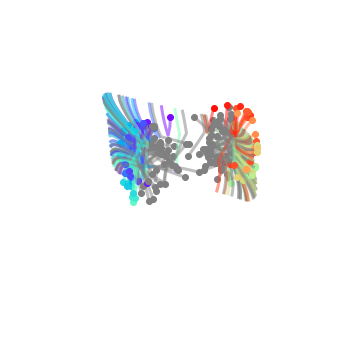

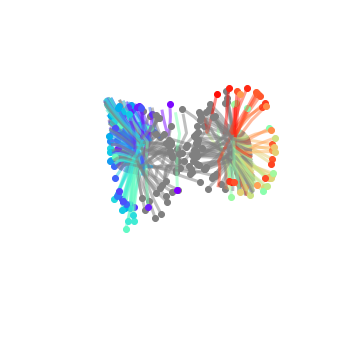

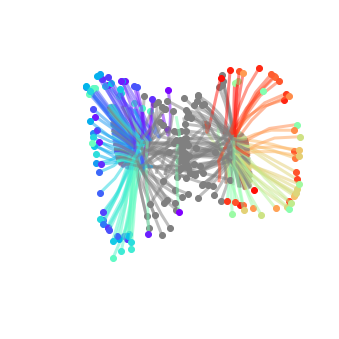

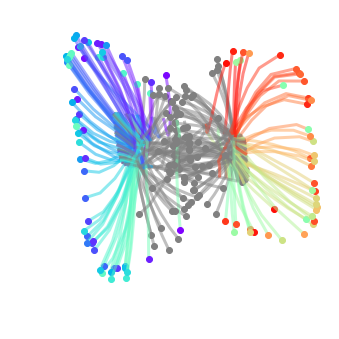

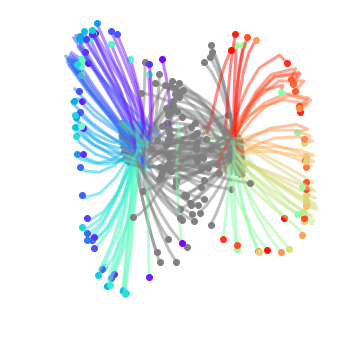

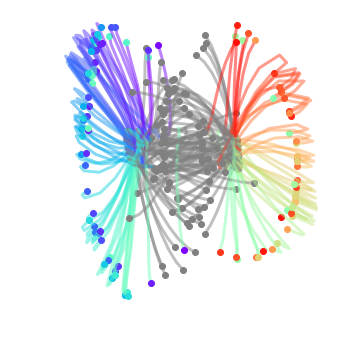

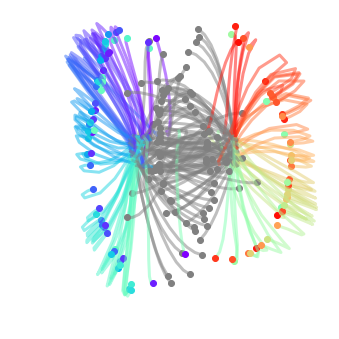

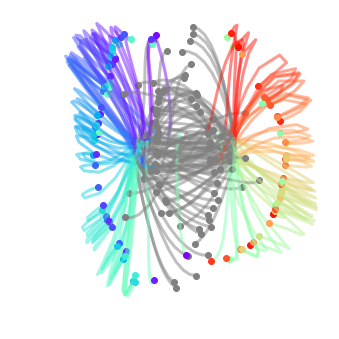

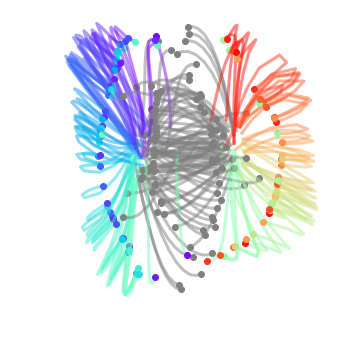

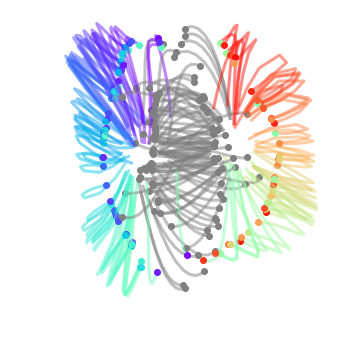

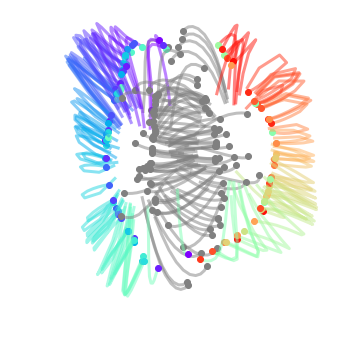

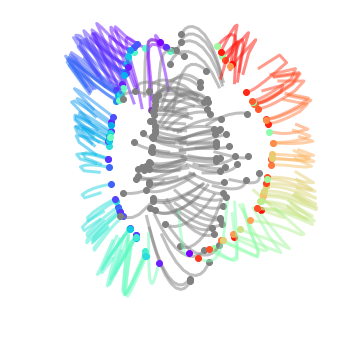

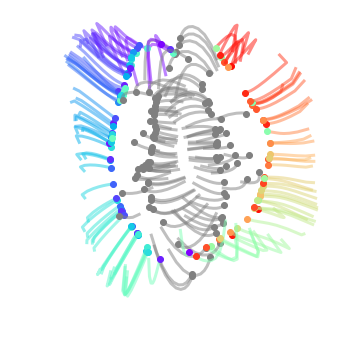

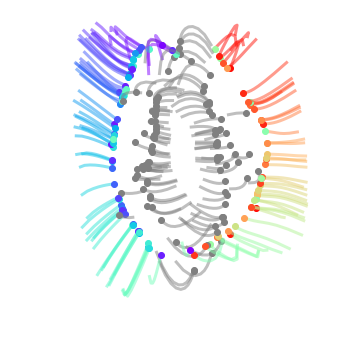

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


IndexError: index 28 is out of bounds for axis 0 with size 11

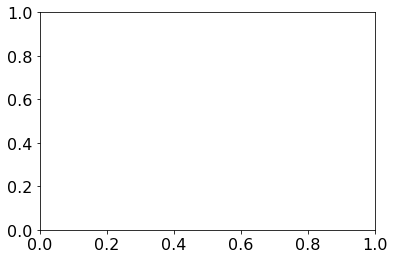

In [69]:
tasks = [18,]

n_trials = np.shape(trial_master.x)[1]
trial_set = range(0,n_trials)

T_end = np.shape(trial_master.x)[0]
T_start = 1
time_inds = range(T_start-1,T_end)

fig = plt.figure(figsize=(20,10),tight_layout=True,facecolor='white')
xlims,ylims = plot_h_struct_multi_stim(model_dir_all,ckpt_n_dir,tasks,trial_set,trial_master,D,time_inds,
                            color_inds,rot = 0,dot_alpha = 1,line_alpha = .1)

plt.legend(loc='center right', bbox_to_anchor=[-.2,.5])
fig_title = 'Category_Go'
plt.savefig(fldr+fig_title+'.pdf')
plt.savefig(fldr+fig_title+'.png')
plt.show()

noise_on = False
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master_go = generate_trials('dmcgo', hparams, mode = 'random', batch_size = 50, noise_on=noise_on, delay_fac =1)   
    
fig_title = 'Category_Go_noise'+str(noise_on)
animate_mult_tasks(model_dir_all,ckpt_n_dir,fig_title,D,trial_master,(18,),time_inds,trial_set,xlims,ylims)

noise_on = False
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master_nogo = generate_trials('dmcnogo', hparams, mode = 'random', batch_size = 50, noise_on=noise_on, delay_fac =1)   

plot_epoch(trial_master_go,'stim1',18,rules_dict)
fig_title = 'Category_Anti_noise'+str(noise_on)
animate_mult_tasks(model_dir_all,ckpt_n_dir,fig_title,D,trial_master,(19,),time_inds,trial_set,xlims,ylims)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

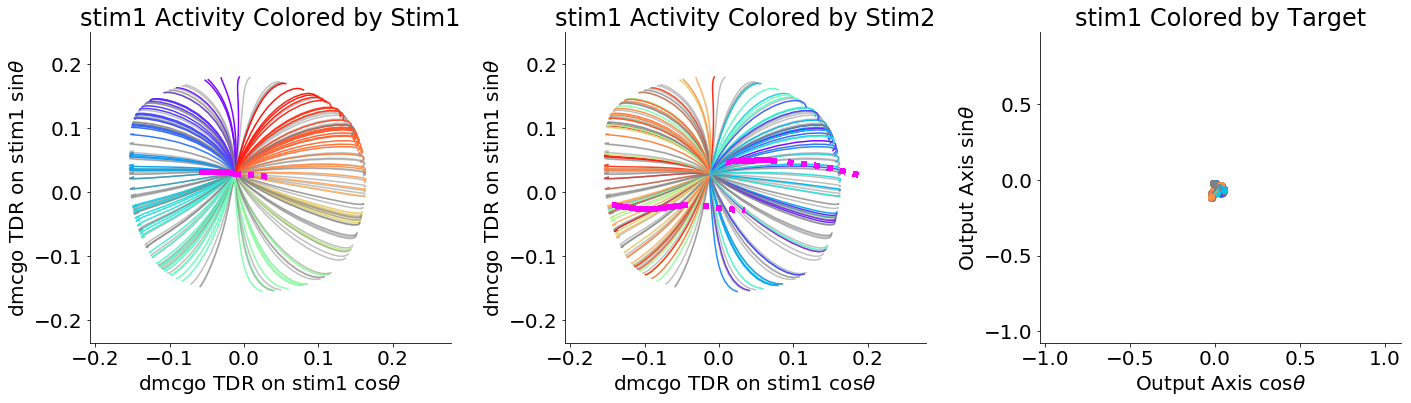

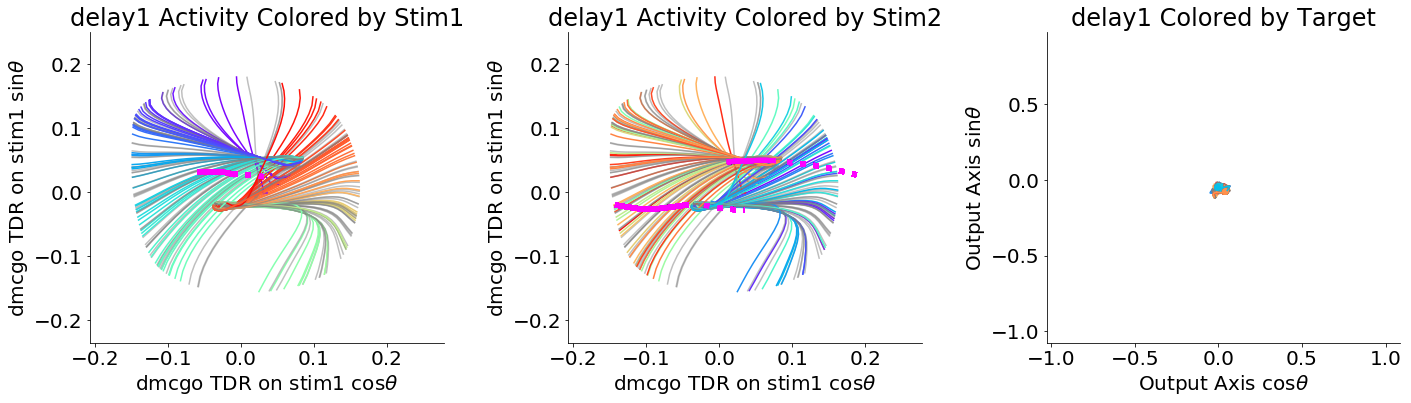

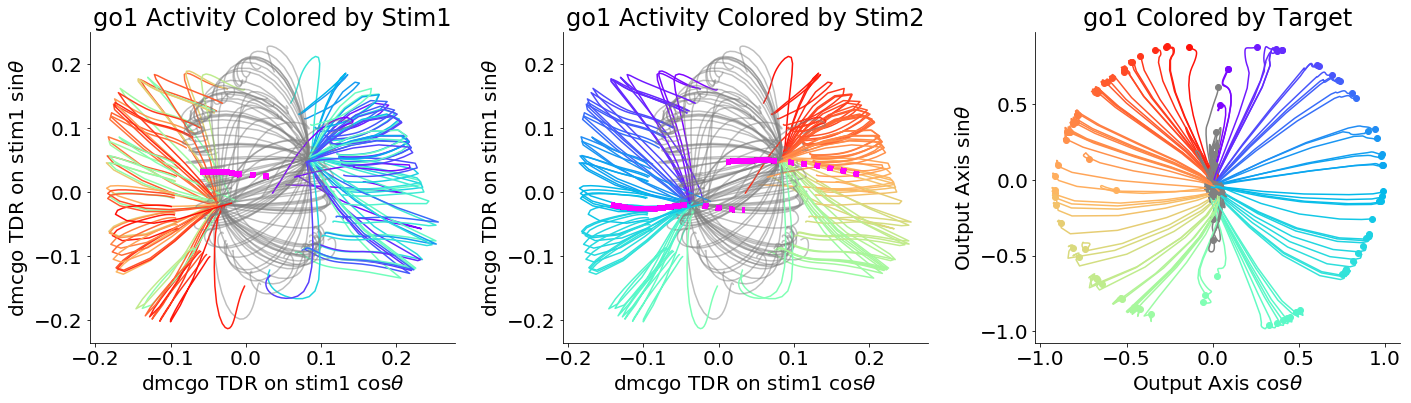

In [18]:
axes_epoch = 'stim1'
h_rule = 'dmcnogo'
axes_rule = 'dmcgo'

b_cat_nogo,trial,D,X_pca_shaped,X_wout_shaped,stim1_locs,stim2_locs = get_cat_vecs(model_dir_all,h_rule,axes_rule,axes_epoch)
vis_cat_vecs(b_cat_nogo, trial, D, axes_rule, X_pca_shaped, X_wout_shaped, stim1_locs, stim2_locs,200,vec_color = 'magenta')

plt.savefig(fldr+h_rule+'_activity_all_epochs.pdf')
plt.savefig(fldr+h_rule+'_activity_all_epochs.png')
plt.show()

In [21]:
#visualize activity and category vectors
def vis_cat_vecs_small(b_cat, D, c, task_name):
    for vi in range(int(np.shape(b_cat)[1]/2)):
        cat_line = np.dot(b_cat[:,vi,:],D)
        if vi==0:
            plt.plot(cat_line[:,0],cat_line[:,1],c = c,alpha = 1,linewidth = 5,label = task_name +' Category A')
            cat_line = np.dot(b_cat[:,vi+int(np.shape(b_cat)[1]/2),:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],':',c = c,alpha = 1,linewidth = 5,label = task_name +' Category B')
        else: 
            plt.plot(cat_line[:,0],cat_line[:,1],c = c,alpha = 1,linewidth = 5)
            cat_line = np.dot(b_cat[:,vi+int(np.shape(b_cat)[1]/2),:],D)
            plt.plot(cat_line[:,0],cat_line[:,1],':',c = c,alpha = 1,linewidth = 5)

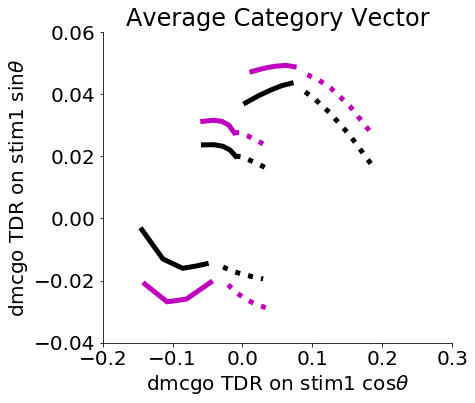

In [25]:
cmap_nogo=plt.get_cmap('Oranges')

fig = plt.figure(figsize=(7,6),tight_layout=True,facecolor='white')
ax1 = plt.subplot(1,1,1)
vis_cat_vecs_small(b_cat_go, D,'k','GO')
vis_cat_vecs_small(b_cat_nogo, D,'m','NOGO')
plt.xlabel(axes_rule + ' TDR on ' + axes_epoch + r' $\cos{\theta}$')
plt.ylabel(axes_rule + ' TDR on ' + axes_epoch + r' $\sin{\theta}$')
plt.ylim((-.04,.06))
plt.xlim((-.2,.3))
# plt.axis('off')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.title('Average Category Vector')
# plt.legend(loc='center left', bbox_to_anchor=[1,.5])

plt.savefig(fldr+'AverageCategoryVector_BOTH.pdf')
plt.savefig(fldr+'AverageCategoryVector_BOTH.png')
plt.show()

In [53]:
from tools_lnd import angle_between
b_cat = np.concatenate((b_cat_go,b_cat_nogo),axis = 1)
v = b_cat[1,:,:] - b_cat[0,:,:]
n_vecs = np.shape(v)[0]

ab = np.zeros((n_vecs,n_vecs))
for vi1 in range(n_vecs):
    for vi2 in range(n_vecs):
        ab_temp = 180*angle_between(v[vi1, :],v[vi2, :])/np.pi
        if ab_temp>90:
            ab_temp = 90 - (ab_temp%90)
        ab[vi1,vi2] = ab_temp

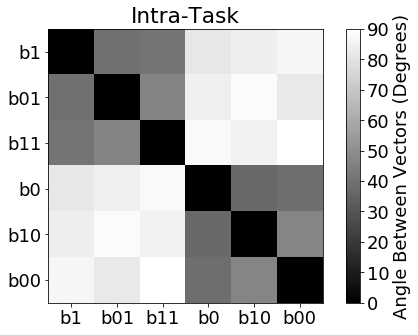

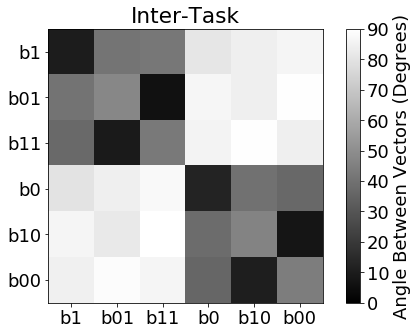

In [54]:
n_vecs = np.shape(b_cat_go)[1]

fig = plt.figure(figsize=(7,5),tight_layout=True,facecolor='white')
plt.imshow(ab[:n_vecs,:n_vecs],cmap = 'gray',clim = [0,90])
cbar = plt.colorbar()
plt.title('Intra-Task')
cbar.ax.set_ylabel('Angle Between Vectors (Degrees)')
plt.yticks(range(n_vecs), ['b1','b01','b11','b0','b10','b00'])
plt.xticks(range(n_vecs), ['b1','b01','b11','b0','b10','b00'])
plt.savefig(fldr+h_rule+'_Intra_AngleVectorMat.pdf')
plt.savefig(fldr+h_rule+'_Intra_AngleVectorMat.png')
plt.show()

fig = plt.figure(figsize=(7,5),tight_layout=True,facecolor='white')
plt.imshow(ab[n_vecs:,:n_vecs],cmap = 'gray',clim = [0,90])
cbar = plt.colorbar()
plt.title('Inter-Task')
cbar.ax.set_ylabel('Angle Between Vectors (Degrees)')
plt.yticks(range(n_vecs), ['b1','b01','b11','b0','b10','b00'])
plt.xticks(range(n_vecs), ['b1','b01','b11','b0','b10','b00'])

plt.savefig(fldr+h_rule+'_Inter_AngleVectorMat.pdf')
plt.savefig(fldr+h_rule+'_Inter_AngleVectorMat.png')
plt.show()

In [130]:
def plot_angle_mat(sub_mat):
    plt.plot(npr.randn(1)*.1,np.diag(sub_mat)[1],'og',alpha = a,label = 'Same History, Same Current Category')
    plt.plot(npr.randn(1)*.1,np.diag(sub_mat)[2],'og',alpha = a)
    plt.plot(npr.randn(1)*.1,np.diag(sub_mat)[4],'og',alpha = a)
    plt.plot(npr.randn(1)*.1,np.diag(sub_mat)[5],'og',alpha = a)

    plt.plot(1+npr.randn(1)*.1,sub_mat[1,2],'ob',alpha = a,label = 'Diff History, Same Current Category')
    plt.plot(1+npr.randn(1)*.1,sub_mat[2,1],'ob',alpha = a)
    plt.plot(1+npr.randn(1)*.1,sub_mat[4,5],'ob',alpha = a)
    plt.plot(1+npr.randn(1)*.1,sub_mat[5,4],'ob',alpha = a)

    plt.plot(2+npr.randn(3)*.1,sub_mat[3:,0],'or',alpha = a,label = 'Diff Current Category')
    plt.plot(2+npr.randn(3)*.1,sub_mat[3:,1],'or',alpha = a)
    plt.plot(2+npr.randn(3)*.1,sub_mat[3:,2],'or',alpha = a)

In [134]:
fldr

'/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/1/category_boundary/'

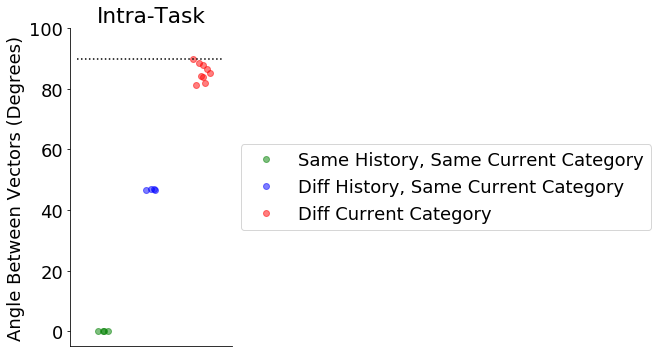

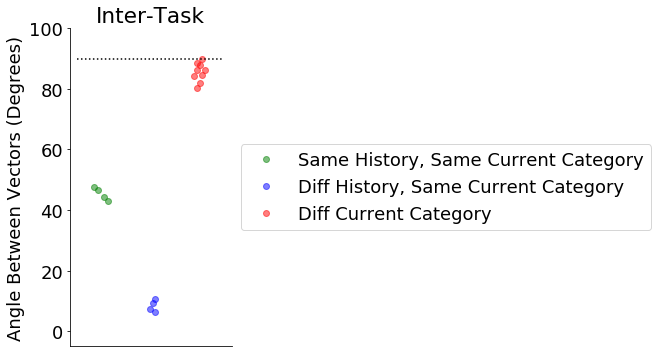

In [133]:
a = .5
n_vecs = np.shape(b_cat_go)[1]
intra = ab[:n_vecs,:n_vecs]
inter = ab[n_vecs:,:n_vecs]

fig = plt.figure(figsize=(12,10),tight_layout=True,facecolor='white')
ax = plt.subplot(2,2,1)
plot_angle_mat(intra)
plt.plot([-.5,2.5],[90,90],':k')
plt.xticks([])
plt.ylim((-5,100))
plt.ylabel('Angle Between Vectors (Degrees)')
plt.title('Intra-Task')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])
plt.savefig(fldr+h_rule+'_Intra_AngleVectorPlot.pdf')
plt.savefig(fldr+h_rule+'_Intra_AngleVectorPlot.png')
plt.show()

fig = plt.figure(figsize=(12,10),tight_layout=True,facecolor='white')
ax = plt.subplot(2,2,1)
plot_angle_mat(inter)
plt.plot([-.5,2.5],[90,90],':k')
plt.xticks([])
plt.ylim((-5,100))
plt.title('Inter-Task')
plt.ylabel('Angle Between Vectors (Degrees)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])
plt.savefig(fldr+h_rule+'_Inter_AngleVectorPlot.pdf')
plt.savefig(fldr+h_rule+'_Inter_AngleVectorPlot.png')
plt.show()

In [137]:
np.shape(v)

(12, 256)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1248000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/1/ckpts/model.ckpt-1052000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/3/ckpts/model.ckpt-880000
either
either
either
either
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/

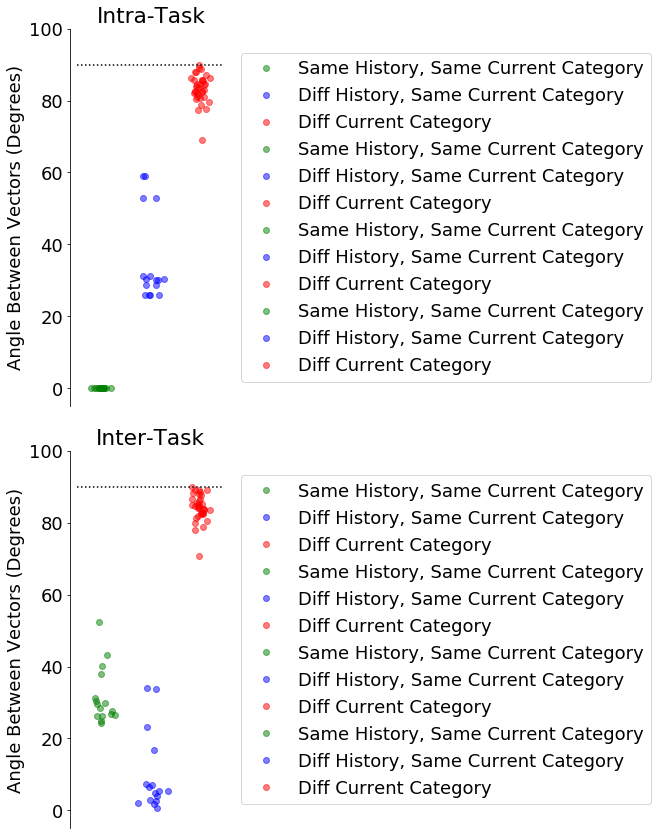

In [140]:
fig = plt.figure(figsize=(12,12),tight_layout=True,facecolor='white')
net = 'stepnet'
a = .5

dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2w0001'#''crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/

for model_n in range(4):
    model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

    b_cat_nogo,_,_,_,_,_,_ = get_cat_vecs(model_dir_all,'dmcnogo',axes_rule,axes_epoch)
    b_cat_go,_,_,_,_,_,_ = get_cat_vecs(model_dir_all,'dmcgo',axes_rule,axes_epoch)

    b_cat = np.concatenate((b_cat_go,b_cat_nogo),axis = 1)
    v = b_cat[1,:,:] - b_cat[0,:,:]
    n_vecs = np.shape(v)[0]
    
    ## reduce rank
    trial = gen_trials_from_model_dir(model_dir_all,'dmcgo')
    X_go,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    trial = gen_trials_from_model_dir(model_dir_all,'dmcnogo')
    X_nogo,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    X = np.concatenate((X_go,X_nogo),axis=1)
    _ = pca.fit_transform(X.T)
    D = np.dot(pca.components_.T,pca.components_)
    v_pca = np.dot(v,D)

    ab = np.zeros((n_vecs,n_vecs))
    for vi1 in range(n_vecs):
        for vi2 in range(n_vecs):
            ab_temp = 180*angle_between(v_pca[vi1, :],v_pca[vi2, :])/np.pi
            if ab_temp>90:
                ab_temp = 90 - (ab_temp%90)
            ab[vi1,vi2] = ab_temp 
    
    n_subvecs = np.shape(b_cat_go)[1]
    intra = ab[:n_subvecs,:n_subvecs]
    inter = ab[n_subvecs:,:n_subvecs]

    ax1 = plt.subplot(2,2,1)
    plot_angle_mat(intra)

    ax = plt.subplot(2,2,3)
    plot_angle_mat(inter)

ax1 = plt.subplot(2,2,1)
plt.plot([-.5,2.5],[90,90],':k')
plt.xticks([])
plt.ylim((-5,100))
plt.ylabel('Angle Between Vectors (Degrees)')
plt.title('Intra-Task')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])


ax2 = plt.subplot(2,2,3)
plt.plot([-.5,2.5],[90,90],':k')
plt.xticks([])
plt.ylim((-5,100))
plt.title('Inter-Task')
plt.ylabel('Angle Between Vectors (Degrees)')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])

plt.savefig(fldr+h_rule+'AngleVectorPlot_Combined.pdf')
plt.savefig(fldr+h_rule+'AngleVectorPlot_Combined.png')
plt.show()

In [114]:
def get_Jacs(model_dir_all, ckpt_n_dir, rule_num, trial_master):

    fpf = []
    J_np = {}
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        
        trial = same_stim_trial(trial_master, rule_num)
        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
        stim1_locs, stim2_locs, stim1_cats, stim2_cats = get_stim_cats(trial)

        stim1 = trial.epochs['stim1']
        stim2 = trial.epochs['go1']

        inputs_np = []
        inputs_np.append(trial.x[stim1[0],:,:])
        inputs_np.append(trial.x[stim2[0],stim1_cats,:])
        inputs_np.append(trial.x[stim2[0],stim1_cats==0,:])

        states_np = []
        states_np.append(h_tf[stim1[0]-1,:,:])
        states_np.append(h_tf[stim2[0]-1,stim1_cats,:])
        states_np.append(h_tf[stim2[0]-1,stim1_cats==0,:])

        fpf = FixedPointFinder(model.cell,sess)
        
        for bi in range(len(states_np)):
            x_tf, F_tf = fpf._grab_RNN(states_np[bi], inputs_np[bi])
            J_tf = pfor.batch_jacobian(F_tf, x_tf,use_pfor = False)
            J_np[bi] = fpf.session.run(J_tf)
    
    return J_np

In [123]:
def get_jac_tril(J):
    N = np.shape(J)[1]
    T_mat = np.tri(N,k=-1)
    T_mat_long = np.tile(T_mat[:,:,np.newaxis],np.shape(J)[0])
    T_mat_long = np.transpose(T_mat_long,(2,0,1))
    J_flat = J[T_mat_long==1]
    return J_flat

def vis_compare_Jacs(J1,J2,set1,set2,label_titles):
    fig = plt.figure(figsize=(9,3),tight_layout=True,facecolor='white') 
    lim = .8
    
    for xi in range(3):
        J_go = J1[set1[xi]]
        J_nogo = J2[set2[xi]]
        print(np.shape(J1[set1[xi]]),np.shape(J2[set2[xi]]))

        J_go_flat = get_jac_tril(J_go)
        J_nogo_flat = get_jac_tril(J_nogo)
        
        L = np.min([len(J_go_flat),len(J_nogo_flat)])

        plt.subplot(1,3,xi+1)
        plot_ind_list = npr.permutation(L)[1:int(L/100)]
        plt.plot(J_go_flat[plot_ind_list],J_nogo_flat[plot_ind_list],'o',alpha = .2)
        plt.plot([-lim,lim],[-lim,lim],':k')
        plt.ylim((-lim,lim))
        plt.xlim((-lim,lim))
        
        r2 = r2_score(J_go_flat[:L], J_nogo_flat[:L])
        plt.text(-.5,.5,'R2: '+str("{:.3f}".format(r2)))
        
        plt.xlabel('Category Go Task dF/dh entries')
        plt.ylabel('Category NoGo Task dF/dh entries')
        plt.title(label_titles[xi])
        
def vis_compare_Jacs_low_rank(J1,J2,set1,set2,label_titles,D):
    fig = plt.figure(figsize=(18,6),tight_layout=True,facecolor='white') 
    r2 = np.empty((3,1))
    lim = .8
    
    for xi in range(3):
        J_go = J1[set1[xi]]
        J_nogo = J2[set2[xi]]

        J_go_flat = get_jac_tril(np.dot(J_go,D))
        J_nogo_flat = get_jac_tril(np.dot(J_nogo,D))
        
        L = np.min([len(J_go_flat),len(J_nogo_flat)])

        ax = plt.subplot(1,3,xi+1)
        plot_ind_list = npr.permutation(L)[1:int(L/100)]
        plt.plot(J_go_flat[plot_ind_list],J_nogo_flat[plot_ind_list],'o',alpha = .2)
        plt.plot([-lim,lim],[-lim,lim],':k')
        plt.ylim((-lim,lim))
        plt.xlim((-lim,lim))
        
        r2_temp = r2_score(J_go_flat[:L], J_nogo_flat[:L])
        plt.text(-.5,.5,'R2: '+str("{:.3f}".format(r2_temp)))
        r2[xi] = r2_temp
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if xi==0:
            plt.xlabel('Category Go Task dF/dh entries')
            plt.ylabel('Category NoGo Task dF/dh entries')
        plt.title(label_titles[xi])        
        
    return r2

def compute_Jacs_low_rank(J1,J2,set1,set2,label_titles,D):
    r2 = np.empty((3,1))
    lim = .8
    
    for xi in range(3):
        J_go = J1[set1[xi]]
        J_nogo = J2[set2[xi]]

        J_go_flat = get_jac_tril(np.dot(J_go,D))
        J_nogo_flat = get_jac_tril(np.dot(J_nogo,D))
        
        L = np.min([len(J_go_flat),len(J_nogo_flat)])
        
        r2_temp = r2_score(J_go_flat[:L], J_nogo_flat[:L])
        r2[xi] = r2_temp
        
    return r2

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1248000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1248000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/1/ckpts/model.ckpt-1052000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/2/ckpts/model.ckpt-1129000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crys

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/3/ckpts/model.ckpt-880000


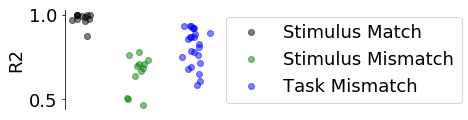

In [127]:
dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2w0001'#''crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/

for model_n in range(4):
    model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

    J_dmcgo = get_Jacs(model_dir_all, ckpt_n_dir, 18, trial_master)
    J_dmcnogo = get_Jacs(model_dir_all, ckpt_n_dir, 19, trial_master)
    J_dmcnogo2 = get_Jacs(model_dir_all, ckpt_n_dir, 19, trial_master)
    J_delayanti = get_Jacs(model_dir_all, ckpt_n_dir, 5, trial_master)
    J_fdgo = get_Jacs(model_dir_all, ckpt_n_dir, 0, trial_master)

    trial = gen_trials_from_model_dir(model_dir_all,'dmcgo')
    X_go,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    trial = gen_trials_from_model_dir(model_dir_all,'dmcnogo')
    X_nogo,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    X = np.concatenate((X_go,X_nogo),axis=1)
    _ = pca.fit_transform(X.T)
    D = np.dot(pca.components_.T,pca.components_)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['@ stim1 IC','@ respond category 1 IC','@ respond category 2 IC']
    r2_match = compute_Jacs_low_rank(J_dmcgo,J_dmcnogo,set1,set2,label_titles,D)  

    set1 = [0,1,2]
    set2 = [2,1,2]
    label_titles = ['mismatch IC','@ mismatch IC','@ mismatch IC']
    r2_mismatch = compute_Jacs_low_rank(J_dmcgo,J_dmcnogo,set1,set2,label_titles,D)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['compare w delayanti','compare w delayanti','compare w delayanti']
    r2_task_mismatch = compute_Jacs_low_rank(J_dmcgo,J_delayanti,set1,set2,label_titles,D)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['compare w fdgo','compare w fdgo','compare w fdgo']
    r2_task_mismatch2 = compute_Jacs_low_rank(J_dmcgo,J_fdgo,set1,set2,label_titles,D)  

    ax = plt.subplot(2,2,1)
    if model_n==1:
        plt.plot(npr.randn(3)*.1,r2_match,'ok',alpha = a,label = 'Stimulus Match')
        plt.plot(1+npr.randn(3)*.1,r2_mismatch,'og',alpha = a,label = 'Stimulus Mismatch')
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch2,'ob',alpha = a,label = 'Task Mismatch')
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch,'ob',alpha = a)
    else:
        plt.plot(npr.randn(3)*.1,r2_match,'ok',alpha = a)
        plt.plot(1+npr.randn(3)*.1,r2_mismatch,'og',alpha = a)
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch2,'ob',alpha = a)
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch,'ob',alpha = a)
    
plt.ylabel('R2')
plt.xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])

plt.savefig(fldr+'_r2_combined.pdf')
plt.savefig(fldr+'_r2_combined.png')

plt.show()

In [ ]:
dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2w0001'#''crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/

for model_n in range(4):
    model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

    J_dmcgo = get_Jacs(model_dir_all, ckpt_n_dir, 18, trial_master)
    J_dmcnogo = get_Jacs(model_dir_all, ckpt_n_dir, 19, trial_master)
    J_dmcnogo2 = get_Jacs(model_dir_all, ckpt_n_dir, 19, trial_master)
    J_delayanti = get_Jacs(model_dir_all, ckpt_n_dir, 5, trial_master)
    J_fdgo = get_Jacs(model_dir_all, ckpt_n_dir, 0, trial_master)

    trial = gen_trials_from_model_dir(model_dir_all,'dmcgo')
    X_go,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    trial = gen_trials_from_model_dir(model_dir_all,'dmcnogo')
    X_nogo,_ = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)

    X = np.concatenate((X_go,X_nogo),axis=1)
    _ = pca.fit_transform(X.T)
    D = np.dot(pca.components_.T,pca.components_)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['@ stim1 IC','@ respond category 1 IC','@ respond category 2 IC']
    r2_match = compute_Jacs_low_rank(J_dmcgo,J_dmcnogo,set1,set2,label_titles,D)  

    set1 = [0,1,2]
    set2 = [2,1,2]
    label_titles = ['mismatch IC','@ mismatch IC','@ mismatch IC']
    r2_mismatch = compute_Jacs_low_rank(J_dmcgo,J_dmcnogo,set1,set2,label_titles,D)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['compare w delayanti','compare w delayanti','compare w delayanti']
    r2_task_mismatch = compute_Jacs_low_rank(J_dmcgo,J_delayanti,set1,set2,label_titles,D)

    set1 = [0,1,2]
    set2 = [0,2,1]
    label_titles = ['compare w fdgo','compare w fdgo','compare w fdgo']
    r2_task_mismatch2 = compute_Jacs_low_rank(J_dmcgo,J_fdgo,set1,set2,label_titles,D)  

    ax = plt.subplot(2,2,1)
    if model_n==1:
        plt.plot(npr.randn(3)*.1,r2_match,'ok',alpha = a,label = 'Stimulus Match')
        plt.plot(1+npr.randn(3)*.1,r2_mismatch,'og',alpha = a,label = 'Stimulus Mismatch')
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch2,'ob',alpha = a,label = 'Task Mismatch')
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch,'ob',alpha = a)
    else:
        plt.plot(npr.randn(3)*.1,r2_match,'ok',alpha = a)
        plt.plot(1+npr.randn(3)*.1,r2_mismatch,'og',alpha = a)
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch2,'ob',alpha = a)
        plt.plot(2+npr.randn(3)*.1,r2_task_mismatch,'ob',alpha = a)
    
plt.ylabel('R2')
plt.xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=[1,.5])

plt.savefig(fldr+'_r2_combined.pdf')
plt.savefig(fldr+'_r2_combined.png')

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1248000


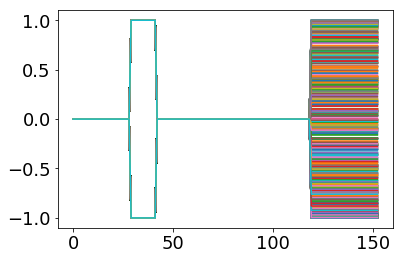

In [115]:
model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial = generate_trials('dmcgo', hparams, mode = 'random', batch_size = 1000, noise_on=False, delay_fac =1)   

T1 = range(trial.epochs['stim1'][0],trial.epochs['stim1'][1])
n_trials = np.shape(trial.x)[1]
half_trials = int(n_trials/2)

new_trial = trial
mod1 = trial.stim_locs[0,0]<100

if mod1:
    sin_stim = 1
    set_other = range(2,5)
else:
    sin_stim = 3
    set_other = [1,2,4]
    
new_trial.x[T1,:half_trials,sin_stim] = 1
for s in set_other:
    new_trial.x[T1,:half_trials,s] = 0
new_trial.x[:,half_trials:,:] = trial.x[:,:half_trials,:]
new_trial.x[T1,half_trials:,sin_stim] = -1

trial_master = new_trial
trial_master.stim_locs[:half_trials,2] = np.pi/2
trial_master.stim_locs[half_trials:,2] = 3*np.pi/2
trial_master.stim_locs[half_trials:,3] = trial_master.stim_locs[:half_trials,3]

# plt.plot(new_trial.x[:,2,1])
plt.plot(new_trial.x[:,:,3])
plt.show()

In [ ]:
J_dmcgo = get_Jacs(model_dir_all, 18, trial_master)
J_dmcnogo = get_Jacs(model_dir_all, 19, trial_master)
J_dmcnogo2 = get_Jacs(model_dir_all, 19, trial_master)
J_delayanti = get_Jacs(model_dir_all, 5, trial_master)
J_fdgo = get_Jacs(model_dir_all, 0, trial_master)

In [31]:
set1 = [0,1,2]
set2 = [0,2,1]
label_titles = ['@ stim1 IC','@ respond category 1 IC','@ respond category 2 IC']

vis_compare_Jacs(J_dmcgo,J_dmcnogo,set1,set2,label_titles)
    
plt.show()

NameError: name 'vis_compare_Jacs' is not defined

In [ ]:
set1 = [0,1,2]
set2 = [2,1,2]
label_titles = ['mismatch IC','@ mismatch IC','@ mismatch IC']

vis_compare_Jacs(J_dmcgo,J_dmcnogo,set1,set2,label_titles)
    
plt.show()

In [ ]:
set1 = [0,1,2]
set2 = [0,2,1]
label_titles = ['compare w delayanti','compare w delayanti','compare w delayanti']
fig = plt.figure(figsize=(9,3),tight_layout=True,facecolor='white') 

vis_compare_Jacs(J_dmcgo,J_delayanti,set1,set2,label_titles)
    
plt.show()

In [128]:
fldr

'/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/1/category_boundary/'

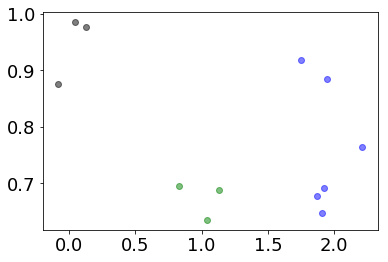

In [126]:
plt.plot(npr.randn(3)*.1,r2_match,'ok',alpha = a,label = 'Stimulus Match')
plt.plot(1+npr.randn(3)*.1,r2_mismatch,'og',alpha = a,label = 'Stimulus Mismatch')
plt.plot(2+npr.randn(3)*.1,r2_task_mismatch2,'ob',alpha = a,label = 'Task Mismatch')
plt.plot(2+npr.randn(3)*.1,r2_task_mismatch,'ob',alpha = a)

In [120]:
plt.show()

In [76]:
def comp_eig_decomp(Ms, sort_by='real',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

In [79]:
np.shape(J_np)

(1000, 256, 256)

In [80]:
eig_decomps = comp_eig_decomp(J_np[:10,:,:])

Text(0.5,1,'max eigenval : 1.0196985')

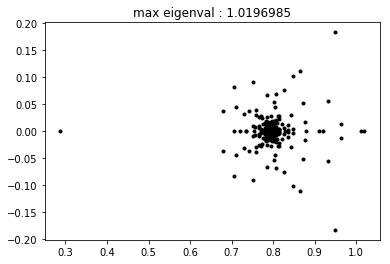

In [82]:
nfp = 0
plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,'.k')
plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)))

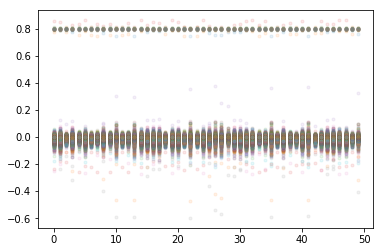

In [73]:
plt.plot(J_np_flat[:50,:10000],'.',alpha = .1)
plt.show()